## 2c. Training Keras Sequential Model.
### Note: To rerun this notebook, must delete the 'predictive_analysis/models' folder first to avoid data leakage.

In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
df = pd.read_csv("../preprocessed/clean_survey.csv")

# Split to independent and dependent variables
X = df.drop(['q_031_adjusted', 'invol_score', 'q_031', 'involvement_level'] + [f'q_0{i}' for i in range(45, 55)], axis=1)
y = df["involvement_level"]

# Encode the class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified split to ensure similar distribution of classes in train/test sets
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, random_state=42)


# Data Preprocessing
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store in dataframe for plotting
feature_names = X_train.columns.tolist()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

2024-05-30 23:51:58.437780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 23:51:58.573766: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 23:51:58.575707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 23:52:02.424609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Shape of X_train_scaled:", X_train_scaled.shape)  # Should be (num_samples, num_features)
print("Shape of y_encoded_train:", y_encoded_train.shape)  # Should be (num_samples,)

Shape of X_train_scaled: (656, 91)
Shape of y_encoded_train: (656,)


In [3]:
# fixed a random state for stability
def reset_random_seeds():
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)

reset_random_seeds()


In [4]:
from tensorflow.keras import regularizers
# Function to build the Keras model with tunable hyperparameters
def build_model(hp):
    model = Sequential()

    # Add input layer with shape based on the number of input features
    model.add(layers.Input(shape=(X_train.shape[1],)))

    # Add a varying number of hidden layers with tunable units and activations
    num_layers = hp.Int('num_layers', 1, 5)
    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)

        # Add regularization and activation for each dense layer
        model.add(layers.Dense(
            units=units,
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh']),
            kernel_regularizer=regularizers.l1(hp.Float(f'l1_regularizer_{i}', 0.0001, 0.01, sampling='log'))
        ))

        # Add a dropout layer with tunable dropout rate
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.6, step=0.1)))

    # Add an output layer with softmax activation to predict class probabilities
    model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

    # Choose optimizer type and learning rate based on hyperparameters
    optimizer_name = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.01, sampling='log')

    # Initialize the optimizer
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compile the model using sparse categorical crossentropy for classification
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded_train), y=y_encoded_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='models_copy',
    project_name='neural_tuning_copy'
)

# Early stopping callback
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Execute the search with stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



# Execute hyperparameter tuning with cross-validation
for train_idx, val_idx in skf.split(X_train_scaled, y_encoded_train):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_encoded_train[train_idx], y_encoded_train[val_idx]

    tuner.search(X_train_fold, y_train_fold, epochs=50, validation_data=(X_val_fold, y_val_fold),
                 callbacks=[stop_early], class_weight=class_weight_dict)

# Get the optimal hyperparameters and best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 20 Complete [00h 00m 37s]
val_accuracy: 0.6212121248245239

Best val_accuracy So Far: 0.689393937587738
Total elapsed time: 00h 18m 35s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

"""# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded_train), y=y_encoded_train)
class_weights = dict(enumerate(class_weights))
# Check class weights (optional, for your reference)
print("Class weights:", class_weights)"""

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
#model = tuner.hypermodel.build(best_hps)
model = tuner.get_best_models(num_models=1)[0]
model.summary()
# Model training
#history = model.fit(X_train_scaled, y_encoded_train, epochs=50, 
#                    class_weight=class_weights, validation_split=0.2, batch_size=32)

# Train the best model on the entire training set with early stopping
"""history = model.fit(X_train_scaled, y_encoded_train, epochs=50,
                    class_weight=class_weight_dict, validation_data=(X_test_scaled, y_encoded_test),
                    batch_size=32, callbacks=[stop_early])"""

# Save the best model to a file
# model.save('../models/neural_1_tensor.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               11776     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 12163 (47.51 KB)
Trainable params: 12163 (47.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'history = model.fit(X_train_scaled, y_encoded_train, epochs=50,\n                    class_weight=class_weight_dict, validation_data=(X_test_scaled, y_encoded_test),\n                    batch_size=32, callbacks=[stop_early])'

In [7]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, hamming_loss
import numpy as np

# Evaluate the model
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions
# y_test_labels = np.argmax(y_encoded_test, axis=1)  # Convert one-hot to labels for evaluation

# Calculate various metrics
print("Accuracy:", accuracy_score(y_encoded_test, y_pred))
print("F1 Score (Micro):", f1_score(y_encoded_test, y_pred, average='micro'))
print("F1 Score (Macro):", f1_score(y_encoded_test, y_pred, average='macro'))
print("F1 Score (Weighted):", f1_score(y_encoded_test, y_pred, average='weighted'))
print("Hamming Loss:", hamming_loss(y_encoded_test, y_pred))

7/7 [==============================] - 0s 12ms/step
Accuracy: 0.6894977168949772
F1 Score (Micro): 0.6894977168949772
F1 Score (Macro): 0.6393669690209297
F1 Score (Weighted): 0.6958674381059101
Hamming Loss: 0.3105022831050228


In [8]:
# ROC-AUC for multi-class
roc_auc = roc_auc_score(y_encoded_test, y_pred_prob, average='macro', multi_class='ovr')
print("ROC-AUC (Macro):", roc_auc)

ROC-AUC (Macro): 0.8195993481258333


{0: 'High', 1: 'Low', 2: 'Medium'}
7/7 [==============================] - 0s 9ms/step


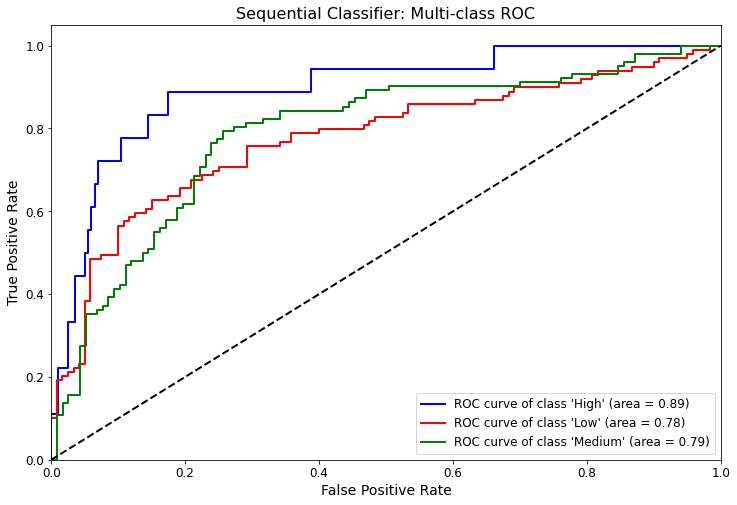

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
from matplotlib import pyplot as plt

label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(label_mapping)

# Binarize the output labels for multi-class ROC curve plotting
y_test_binarized = label_binarize(y_encoded_test, classes=np.unique(y_encoded_train))
n_classes = y_test_binarized.shape[1]

# Colors for different classes
colors = cycle(['blue', 'red', 'green'])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Use model.predict to get the probabilities
y_proba = model.predict(X_test_scaled)

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_binarized[:, j], y_proba[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for j, color in zip(range(n_classes), colors):
    plt.plot(fpr[j], tpr[j], color=color, lw=2,
             label=f"ROC curve of class '{label_mapping[j]}' (area = {roc_auc[j]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Sequential Classifier: Multi-class ROC', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

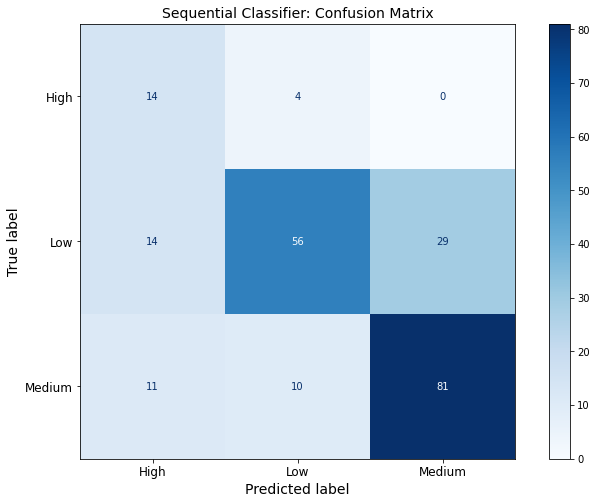

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_encoded_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
# Create a new figure or adjust the current figure size here
fig, ax = plt.subplots(figsize=(12, 8))
# Increase text font size within the matrix
disp.plot(ax=ax, cmap=plt.cm.Blues)  # Plot on the specified axes to control the size

# Now adjust the fontsize using ax properties
ax.set_title(f'Sequential Classifier: Confusion Matrix', fontsize=14)  # Adjust title fontsize
ax.set_xlabel('Predicted label', fontsize=14)  # Adjust x-axis label fontsize
ax.set_ylabel('True label', fontsize=14)  # Adjust y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick fontsize for both axes

plt.show()